## Basic Co-Occurrence Analysis of Human-Cell-Atlas Pancreas Topograhic Maps

Data from Tosti et al, 2021

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [25]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn_image as isns
import seaborn as sns
import scipy.signal as signal
from scipy import stats

import statsmodels.stats.multitest as smm

from sonar import sonar, utils
import math

In [252]:
# Define the cluster labels of the pancreas tissue matrix:

cluster_labels = ['background',
 'Acinar-i',
 'Acinar-s',
 'Acinar-REG+',
 'Activated Stellate',
 'Quiescent Stellate',
 'Alpha',
 'Beta',
 'Gamma (PP)',
 'Delta',
 'Ductal',
 'MUC5B+ Ductal (PDG)',
 'MHC Class II',
 'Schwan',
 'B cell',
 'T cell',
'Endothelial'
]

In [4]:
relevant_cluster_labels =  [
 'Acinar-i',
 'Acinar-s',
 'Acinar-REG+',
 'Activated Stellate',
 'Quiescent Stellate',
 'Alpha',
 'Beta',
 'Gamma (PP)',
 'Delta',
 'Ductal',
 'MUC5B+ Ductal (PDG)',
 'MHC Class II',
 'Schwan',
]

In [5]:
import torch

if torch.cuda.is_available():
    import torch as t
    device = 'cuda:0' # put it in a gpu
else:
    import torch as t
    device='cpu'


## real tissue example

In [6]:
sample_list = []
for sample in range(1,5):
    n_sample = sample

    tissue_matrix = np.load('/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/test/ISS-pancreas/data/sample_matrices.npz')['sample_'+str(n_sample)]
    # Islet stack
    rescaled = utils.rescale_topographic_tensor(tissue_matrix, scaling_factor=0.3).numpy()
    # rescaled_splitted = np.split(rescaled, 16)
    # islet_stack = np.add.reduce([rescaled_splitted[6],rescaled_splitted[7],rescaled_splitted[8],rescaled_splitted[9]])
    sample_list.append(rescaled)


Text(0.5, 1.0, 'Sample4, scaling = 0.3')

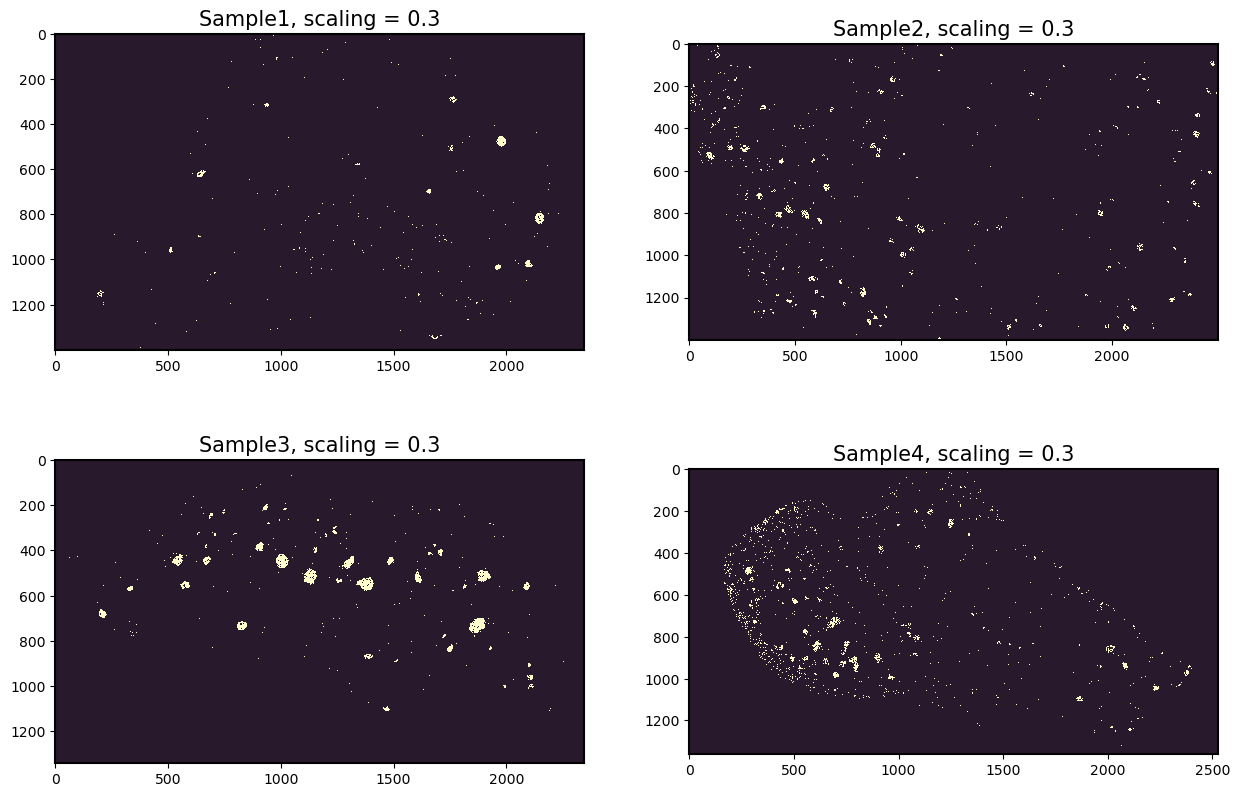

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.imshow(sample_list[0][0][200:1600,:])
plt.title("Sample1, scaling = 0.3")

plt.subplot(2,2,2)
plt.imshow(sample_list[1][0][350:1750,500:3000])
plt.title("Sample2, scaling = 0.3")

plt.subplot(2,2,3)
plt.imshow(sample_list[2][0].T)
plt.title("Sample3, scaling = 0.3")

plt.subplot(2,2,4)
plt.imshow(sample_list[3][0][200:,:])
plt.title("Sample4, scaling = 0.3")

# Normalization

In [276]:
rescaled = sample_list[1]

In [ ]:

cluster_labels = ['background',
 'Acinar-i',
 'Acinar-s',
 'Acinar-REG+',
 'Activated Stellate',
 'Quiescent Stellate',
 'Alpha',
 'Beta',
 'Gamma (PP)',
 'Delta',
 'Ductal',
 'MUC5B+ Ductal (PDG)',
 'MHC Class II',
 'Schwan',
 'B cell',
 'T cell',
]

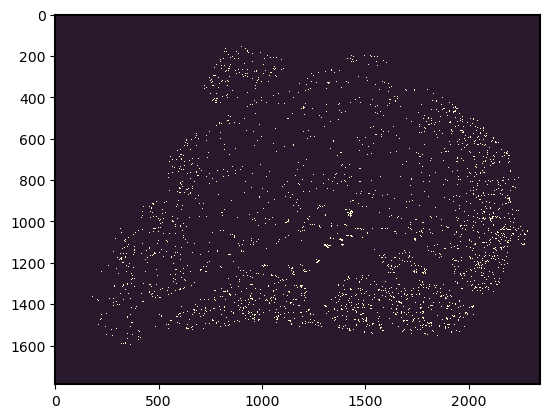

In [269]:
plt.imshow(rescaled[10,:,:])

In [260]:
rescaled.shape

(16, 1954, 3584)

In [277]:
for i in range(1,rescaled.shape[0]):
    print(np.sum(rescaled[i,:,:]))

191874.0
1540189.0
7590.0
4190.0
2267.0
11345.0
24051.0
131.0
2281.0
50775.0
1566.0
1100.0
294.0
0.0
0.0


In [ ]:
relevant_cluster_labels = [
 'Acinar-i',
 'Acinar-s',
 'Acinar-REG+',
 'Activated Stellate',
 'Quiescent Stellate',
 'Alpha',
 'Beta',
 'Gamma (PP)',
 'Delta',
 'Ductal',
 'MUC5B+ Ductal (PDG)',
 'MHC Class II',
 'Schwan'
]

In [304]:
# calculation of the tissue area of each cell-type
def total_pixel_counts(original_img = rescaled, cell_type_labels = relevant_cluster_labels):

    # fig, ax = plt.figure(figsize=[10,3])

    tissue_pixels = []
    for i in range(1,len(cell_type_labels)+1):
        pix_agreg = np.sum(rescaled[i]) # rescaled[i+1] because under 0 here is a background
        tissue_pixels.append(pix_agreg)
        # print(pix_agreg)

    # ax.bar(cell_type_labels,tissue_pixels)
    # ax.set_xticks(rotation=45, ha="right")

    # plt.show()

    return list(tissue_pixels)

pixel_counts = total_pixel_counts(rescaled)

In [305]:
len(pixel_counts)

13

In [9]:
def sig(t, k=1):
    return ((1)/(1+(torch.exp(-t*k))))

def smax(t,k=5):
    return (torch.exp(t*k)/(torch.exp(t*k).sum(0)))

rad_ = 500
lin = 1

In [279]:
son = sonar.Sonar(max_radius=rad_,linear_radius_steps=lin, edge_correction=True, circumference_normalization=True)
cooc_template_all  = son.co_occurrence_from_tensor(rescaled[1:],interpolate="linear", area_normalization = False) 

In [293]:
cooc_template_ = cooc_template_all[:13,:13,:]

In [294]:
cooc_template_.shape

(13, 13, 500)

In [306]:

# Normalisation to the number of pixels of cell-types in the tissue

def normalize_co_occurrence_matrix(tensor = cooc_template_, cell_counts = pixel_counts):
    n, _, m = tensor.shape
    normalized_coocur = np.zeros_like(tensor)
    
    for i in range(n):
        for j in range(n):
            for k in range(m):
                normalized_coocur[i, j, k] = tensor[i, j, k] / cell_counts[j]
    
    return normalized_coocur


normalized_coocur = normalize_co_occurrence_matrix(cooc_template_)

In [307]:
np.max(normalized_coocur)

1.1085959864026718

In [26]:
# COLORS = ["#e6beff", # Mem B zone
#           "#ABEBC6", # Naive B enriched
#           "#E74C3C", # Plasma/Macro enriched
#           "#34b4eb", # Treg/TFH enriched
#           "#FFEB3B", # Stromal zone
#           "#4A148C", # Follicular
#           "#2ECC71", # Mantle zone
#           "#F39C12", # Th Mem zone
#           "#BA68C8", # LZ enriched
#           "#F06292", # Mixed T zone
#           "#204fe8", # DZ enriched
#           "#008080"]

# color_dict = { i:c for i, c in enumerate(COLORS) }

# sns.color_palette(COLORS)

[(0.9019607843137255, 0.7450980392156863, 1.0),
 (0.6705882352941176, 0.9215686274509803, 0.7764705882352941),
 (0.9058823529411765, 0.2980392156862745, 0.23529411764705882),
 (0.20392156862745098, 0.7058823529411765, 0.9215686274509803),
 (1.0, 0.9215686274509803, 0.23137254901960785),
 (0.2901960784313726, 0.0784313725490196, 0.5490196078431373),
 (0.1803921568627451, 0.8, 0.44313725490196076),
 (0.9529411764705882, 0.611764705882353, 0.07058823529411765),
 (0.7294117647058823, 0.40784313725490196, 0.7843137254901961),
 (0.9411764705882353, 0.3843137254901961, 0.5725490196078431),
 (0.12549019607843137, 0.30980392156862746, 0.9098039215686274),
 (0.0, 0.5019607843137255, 0.5019607843137255)]

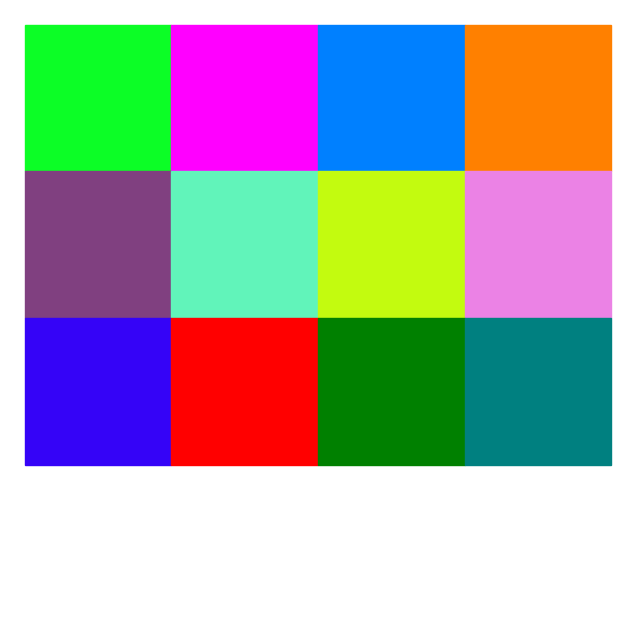

In [47]:
# from distinctipy import distinctipy

# # number of colours to generate
# N = normalized_coocur.shape[0]

# # generate N visually distinct colours
# colors = distinctipy.get_colors(N)

# # display the colours
# distinctipy.color_swatch(colors)

In [285]:
colors = [(0.04539659990856526, 0.9950834146451918, 0.1499488663005254),
 (1.0, 0.0, 1.0),
 (0.0, 0.5, 1.0),
 (1.0, 0.5, 0.0),
 (0.5, 0.25, 0.5),
 (0.3806287930848872, 0.9587938095125506, 0.7309407555134216),
 (0.765350367801373, 0.9841022759439689, 0.05801173998599107),
 (0.9214116218515722, 0.5101069244842528, 0.8965838031677331),
 (0.20848553008387116, 0.012218971422101932, 0.9672051864008775),
 (1.0, 0.0, 0.0),
 (0.0, 0.5, 0.0),
 (0.0, 0.5, 0.5),
 (0.3379250810420038, 0.0247771750361111, 0.6305114722526198),
 ]

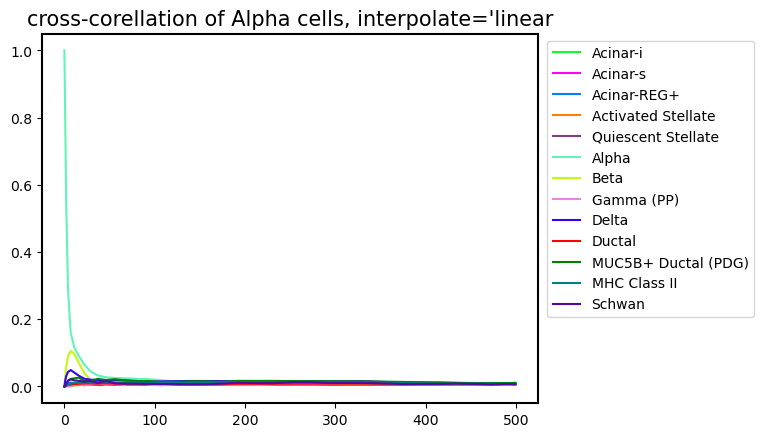

In [308]:
    
for cross_correlated_cell_type in range(normalized_coocur.shape[0]):

    plt.plot(normalized_coocur[5,cross_correlated_cell_type], label = relevant_cluster_labels[cross_correlated_cell_type], color=colors[cross_correlated_cell_type % len(colors)])
    plt.title("cross-corellation of Alpha cells, interpolate='linear")
    plt.legend(loc="upper right", bbox_to_anchor=(1.45, 1))

# plt.ylim(-0.001,0.01)
plt.show()

/tmp/ipykernel_699637/3199293142.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


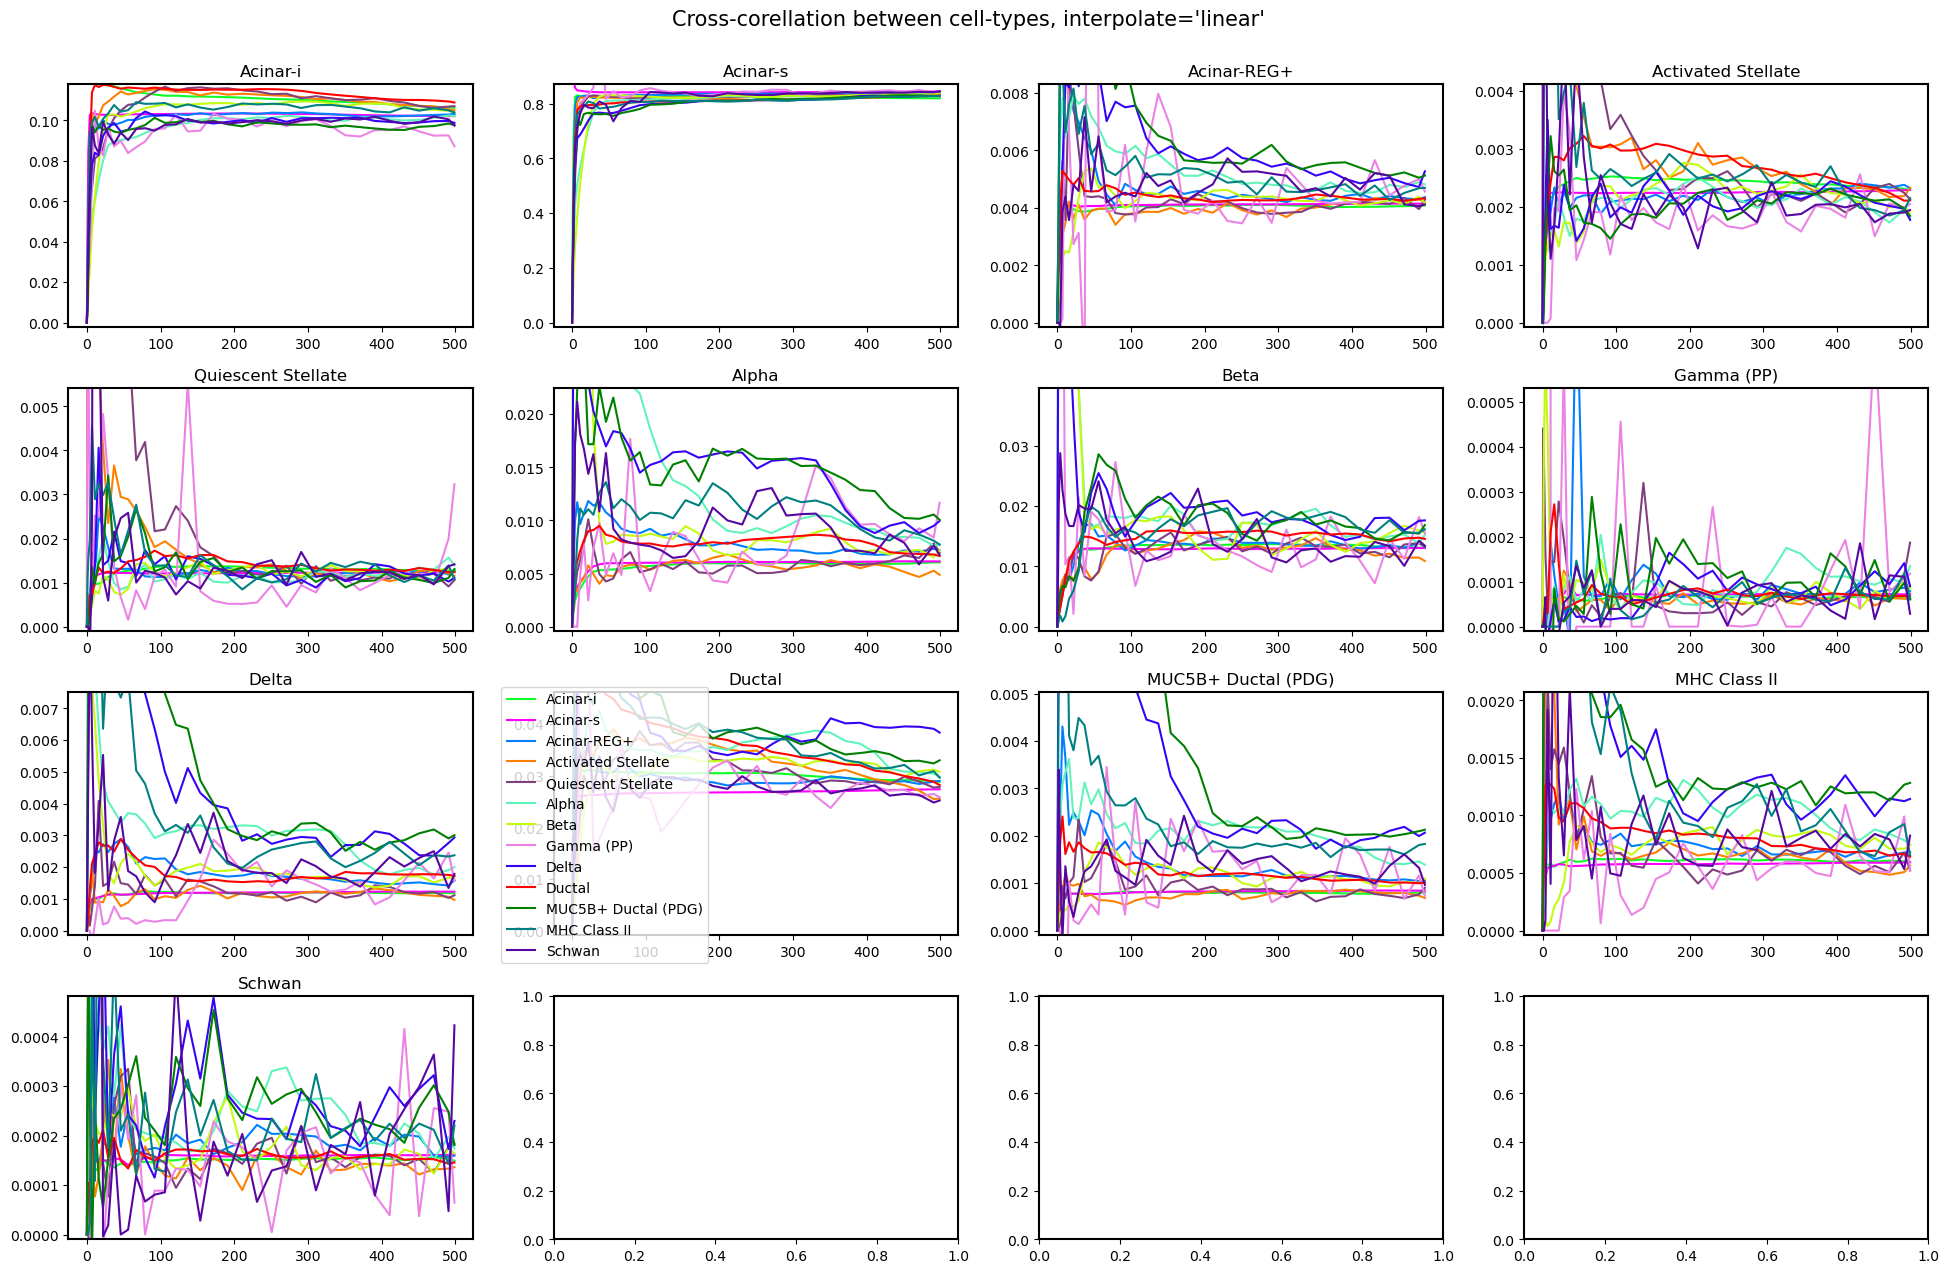

In [309]:
n_rows = 4
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 15), gridspec_kw={'hspace': 0.25})

for pivot_cell_type in range(normalized_coocur.shape[0]):  
    row = pivot_cell_type // n_cols
    col = pivot_cell_type % n_cols
    ax = axes[row, col]

    y_maximum = normalized_coocur[pivot_cell_type,:,10:].mean() + normalized_coocur[pivot_cell_type,:,10:].std()*2

    for target_cell_type in range(normalized_coocur.shape[0]):

        ax.plot(normalized_coocur[pivot_cell_type,target_cell_type], label = relevant_cluster_labels[target_cell_type], color=colors[target_cell_type % len(colors)])
        ax.set_title(f"{relevant_cluster_labels[pivot_cell_type]}",  fontsize=12)
        ax.set_ylim(-y_maximum/50, y_maximum)
    
ax.legend(loc="upper right", bbox_to_anchor=(1.6, 2.3))

plt.suptitle("Cross-corellation between cell-types, interpolate='linear'", fontsize=15, y=0.93)
plt.tight_layout()
plt.show()

## Normality check

In [16]:
cell_types_num = normalized_coocur.shape[0]
distance_num = normalized_coocur.shape[2]

normality_per_distance_unit = np.zeros((cell_types_num, distance_num))

for specific_cell_type in range(normalized_coocur.shape[0]):

    for distance in range(normalized_coocur.shape[2]):
        correlation_per_disrant_unit = normalized_coocur[specific_cell_type,:,distance]

        res = stats.normaltest(correlation_per_disrant_unit)
        dist = stats.chi2(df=2) # null distribution for very large samples is the chi-squared distribution with two degrees of freedom
        norm_res = dist.sf(res.statistic)
        
        normality_per_distance_unit[specific_cell_type, distance] = norm_res


/dh-projects/ag-ishaque/analysis/anastasiia/anaconda3/envs/sonar/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Text(0.5, 1.0, 'Normality of cell-types distribution over distance')

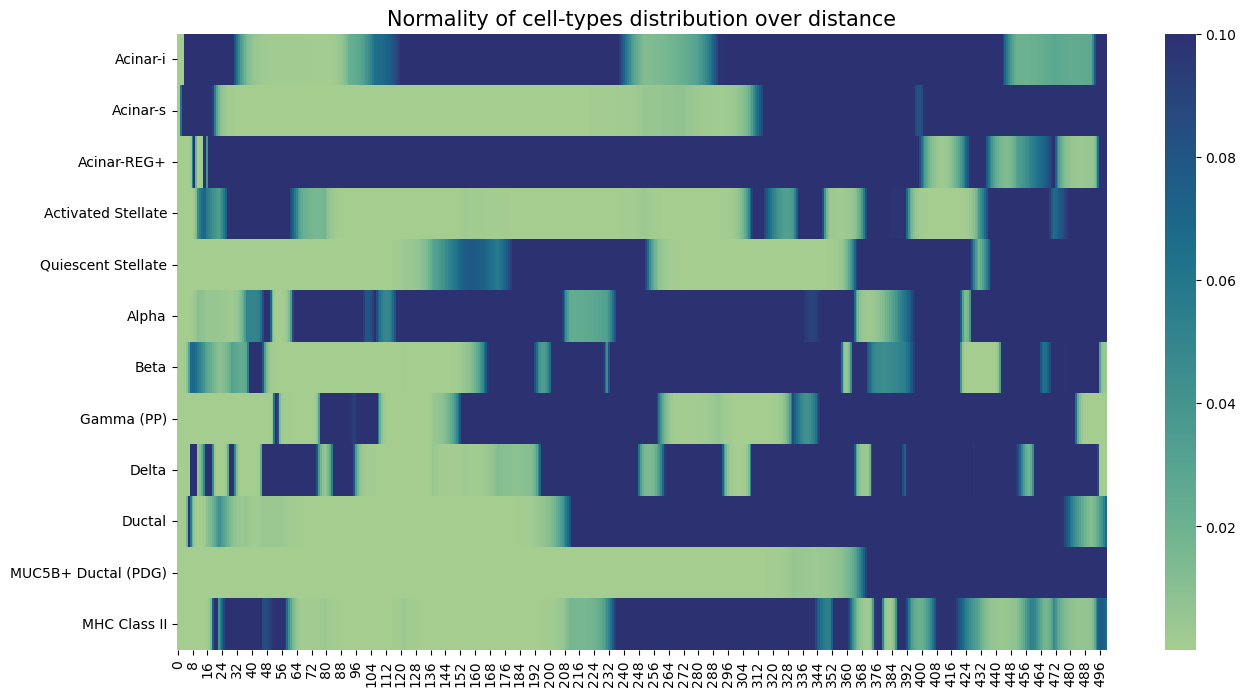

In [35]:
plt.figure(figsize = (15,8))

# plt.subplot(1,2,1)
sns.heatmap(normality_per_distance_unit, cmap="crest", vmax = 0.1, yticklabels = relevant_cluster_labels[:-1])

plt.title("Normality of cell-types distribution over distance")

### Single cell type

In [17]:
normality_check2D = normality_per_distance_unit[1,:,np.newaxis]

normality_check2D.shape

(500, 1)

Text(0.5, 1.0, 'Normality heatmap of Asinar-s cells cross-correlation')

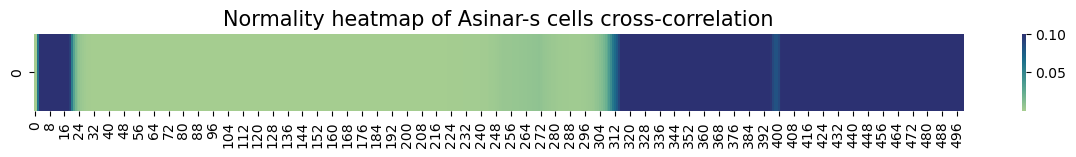

In [33]:
normality_check2D = normality_per_distance_unit[1,:,np.newaxis]

plt.figure(figsize = (15,1))
# plt.subplot(1,2,1)
sns.heatmap(normality_check2D.T, cmap="crest", vmax = 0.1)
plt.title("Normality heatmap of Asinar-s cells cross-correlation")
# plt.subplot(1,2,2)
# sns.heatmap(input_array.T, cmap="flare", vmax = 0.05)



## SIgnificance test

In [310]:
# alternative='less'

significance_test_less = np.zeros((normalized_coocur.shape[0],normalized_coocur.shape[1],normalized_coocur.shape[2]))


for pivot_cell_type in range(normalized_coocur.shape[0]):
    for target_cell_type in range(normalized_coocur.shape[1]):
        for distance in range(normalized_coocur.shape[2]):

            value_to_test = normalized_coocur[pivot_cell_type, target_cell_type, distance]
            t_statistic, p_value = stats.ttest_1samp(normalized_coocur[pivot_cell_type,:,distance], value_to_test, alternative='less')
            significance_test_less[pivot_cell_type, target_cell_type, distance] = p_value


In [312]:
significance_test_flatten_less = significance_test_less.flatten()
corrected_p_values_less = smm.multipletests(significance_test_flatten_less, method='fdr_bh')[1]

In [313]:
corrected_p_values3D_less = corrected_p_values_less.reshape(normalized_coocur.shape[0],normalized_coocur.shape[1],normalized_coocur.shape[2])

In [314]:
# alternative='greater'

significance_test_great = np.zeros((normalized_coocur.shape[0],normalized_coocur.shape[1],normalized_coocur.shape[2]))


for pivot_cell_type in range(normalized_coocur.shape[0]):
    for target_cell_type in range(normalized_coocur.shape[1]):
        for distance in range(normalized_coocur.shape[2]):

            value_to_test = normalized_coocur[pivot_cell_type, target_cell_type, distance]
            t_statistic, p_value = stats.ttest_1samp(normalized_coocur[pivot_cell_type,:,distance], value_to_test, alternative='greater')
            significance_test_great[pivot_cell_type, target_cell_type, distance] = p_value

In [315]:
significance_test_flatten_great = significance_test_great.flatten()
corrected_p_values_great = smm.multipletests(significance_test_flatten_great, method='fdr_bh')[1]

In [316]:
corrected_p_values3D_great = corrected_p_values_great.reshape(normalized_coocur.shape[0],normalized_coocur.shape[1],normalized_coocur.shape[2])

Text(0.5, 1.0, 'Alpha cells, Significance test')

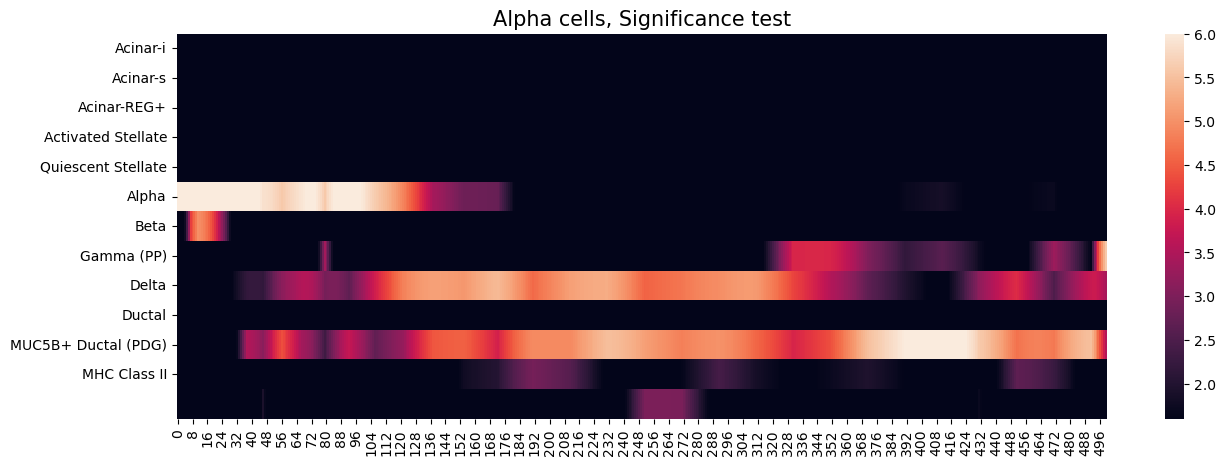

In [317]:
# single cell type

plt.figure(figsize = (15,5))
sns.heatmap(-np.log10(significance_test_less[5,:,:]), cmap="rocket", yticklabels = relevant_cluster_labels[:-1], vmin = 1.6, vmax=6)
plt.title("Alpha cells, Significance test")


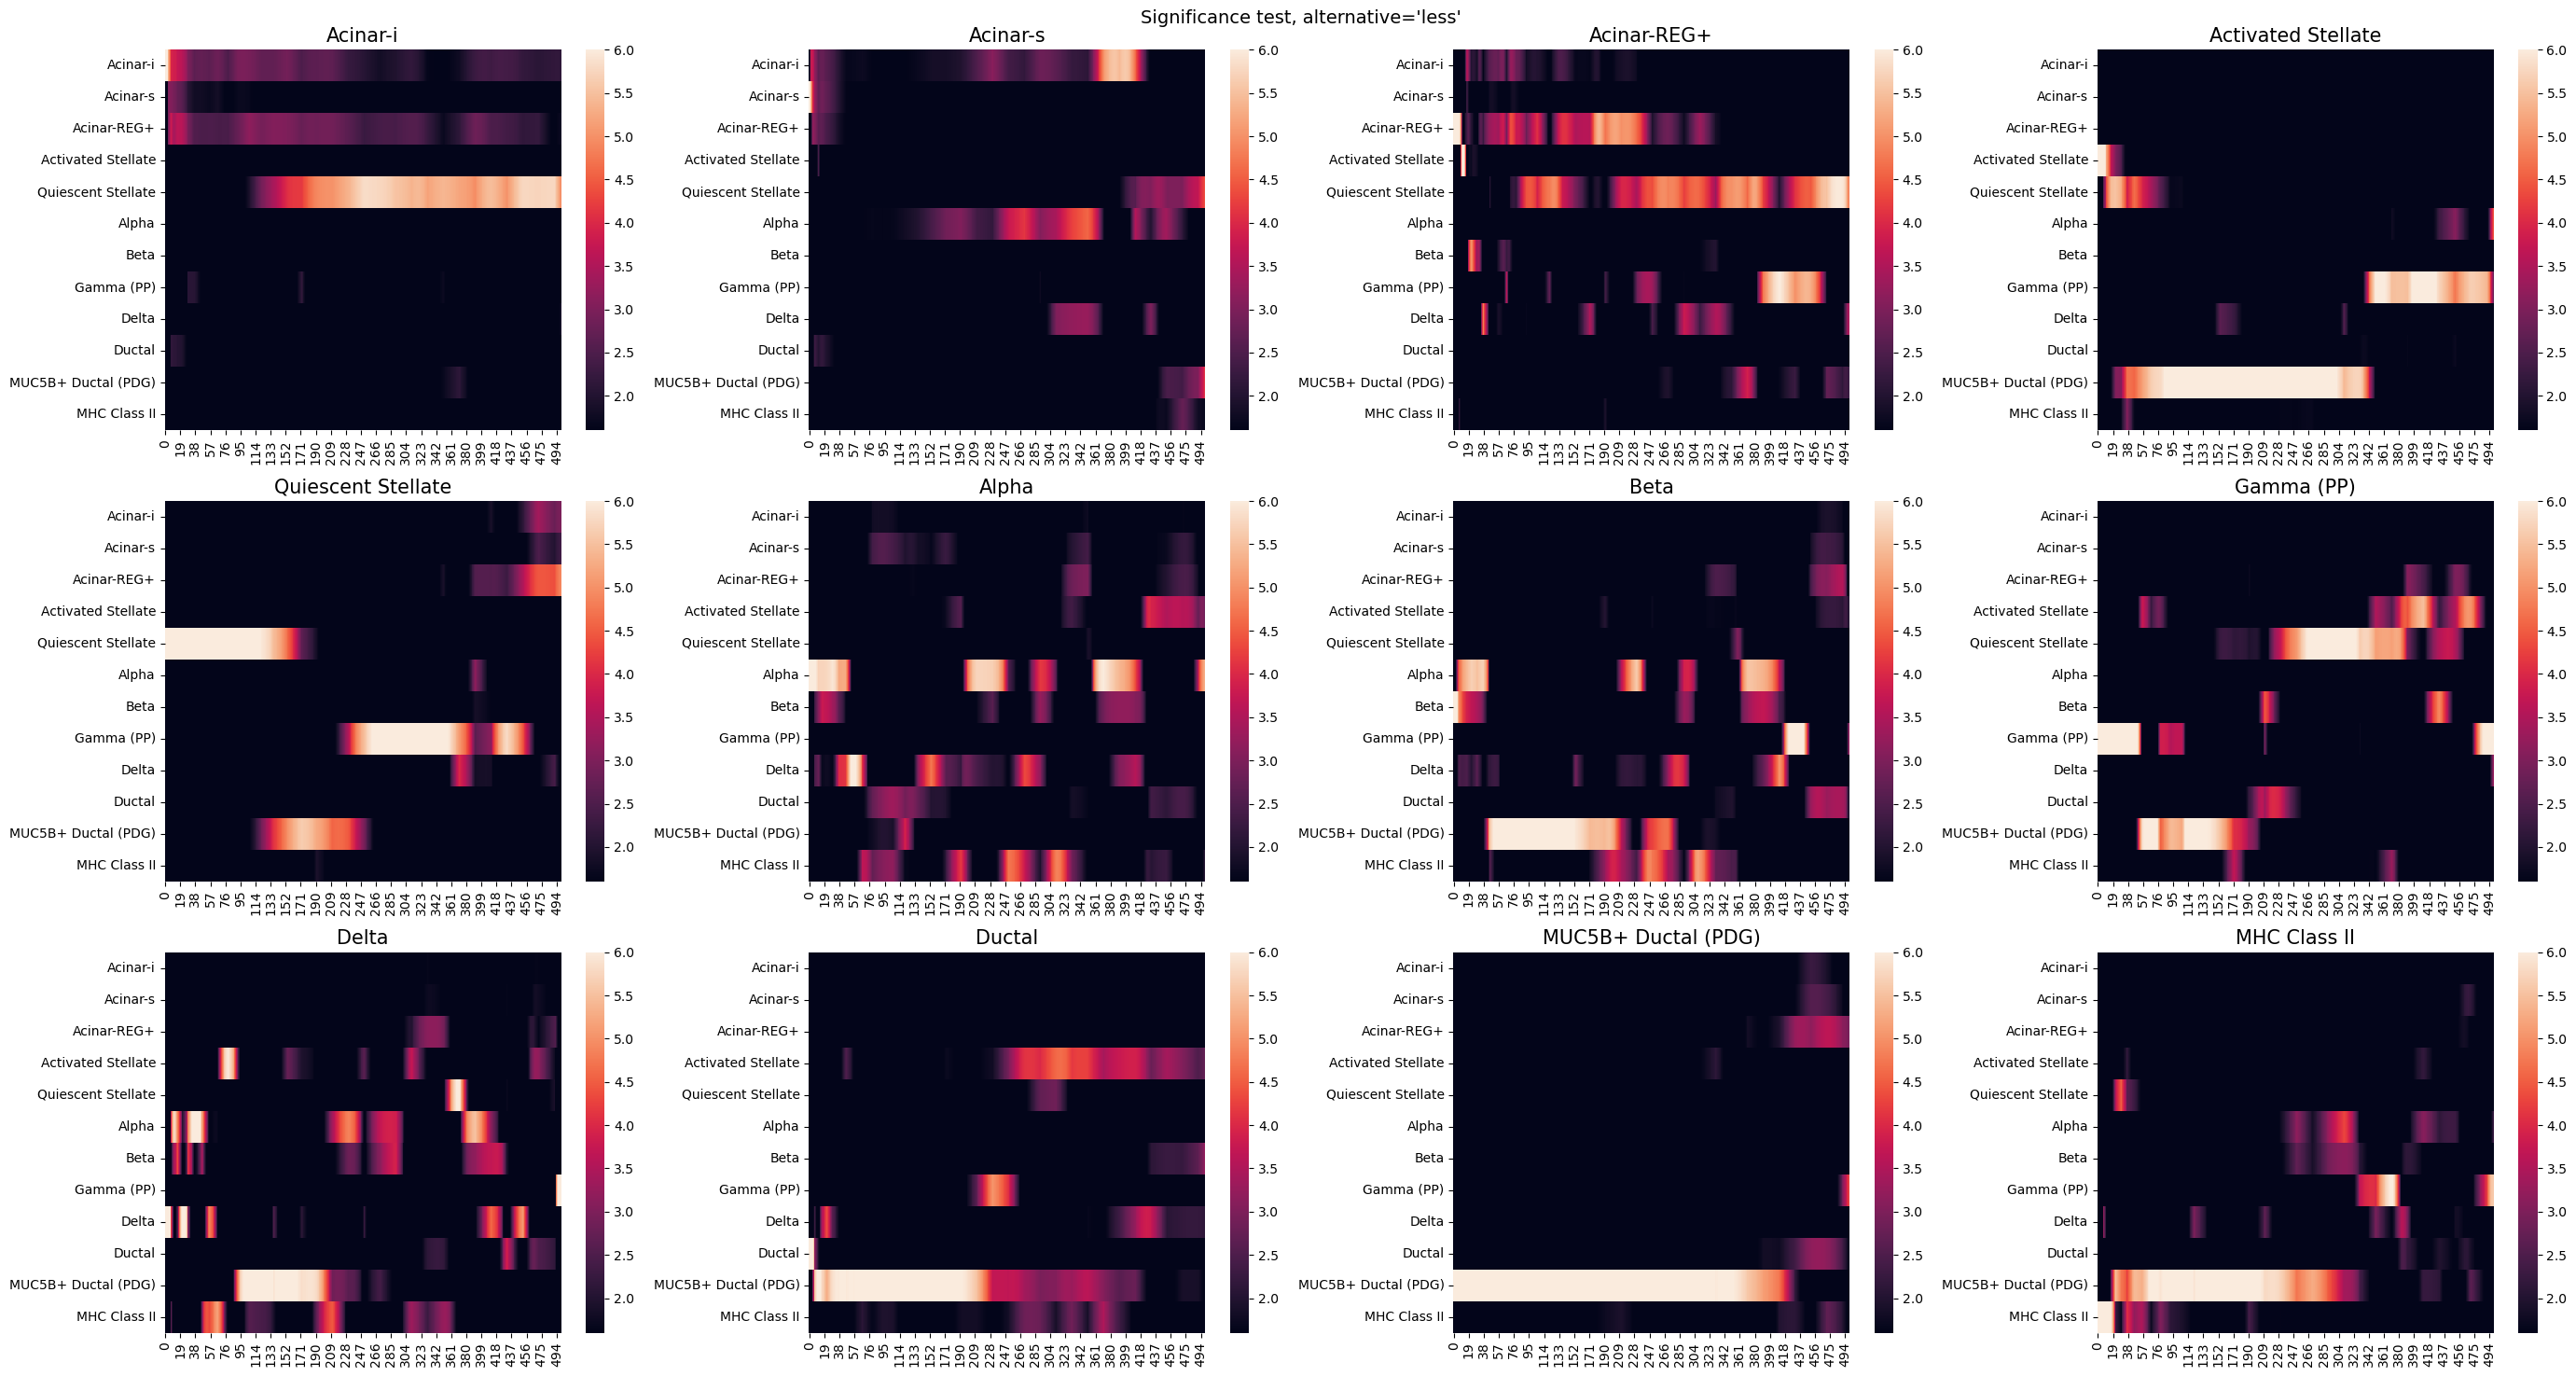

In [45]:
# alternative='less'

n_rows = 3
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize = (28,15))

for pivot_cell_type in range(normalized_coocur.shape[0]):

    row = pivot_cell_type // n_cols
    col = pivot_cell_type % n_cols
    ax = axes[row, col]

    sns.heatmap(-np.log10(significance_test_less[pivot_cell_type,:,:]), cmap="rocket", yticklabels = relevant_cluster_labels[:-1], vmin = 1.6, vmax=6, ax=ax)
    ax.set_title(f"{relevant_cluster_labels[pivot_cell_type]}")

plt.suptitle("Significance test, alternative='less'", fontsize = 14)
plt.tight_layout()
plt.show()

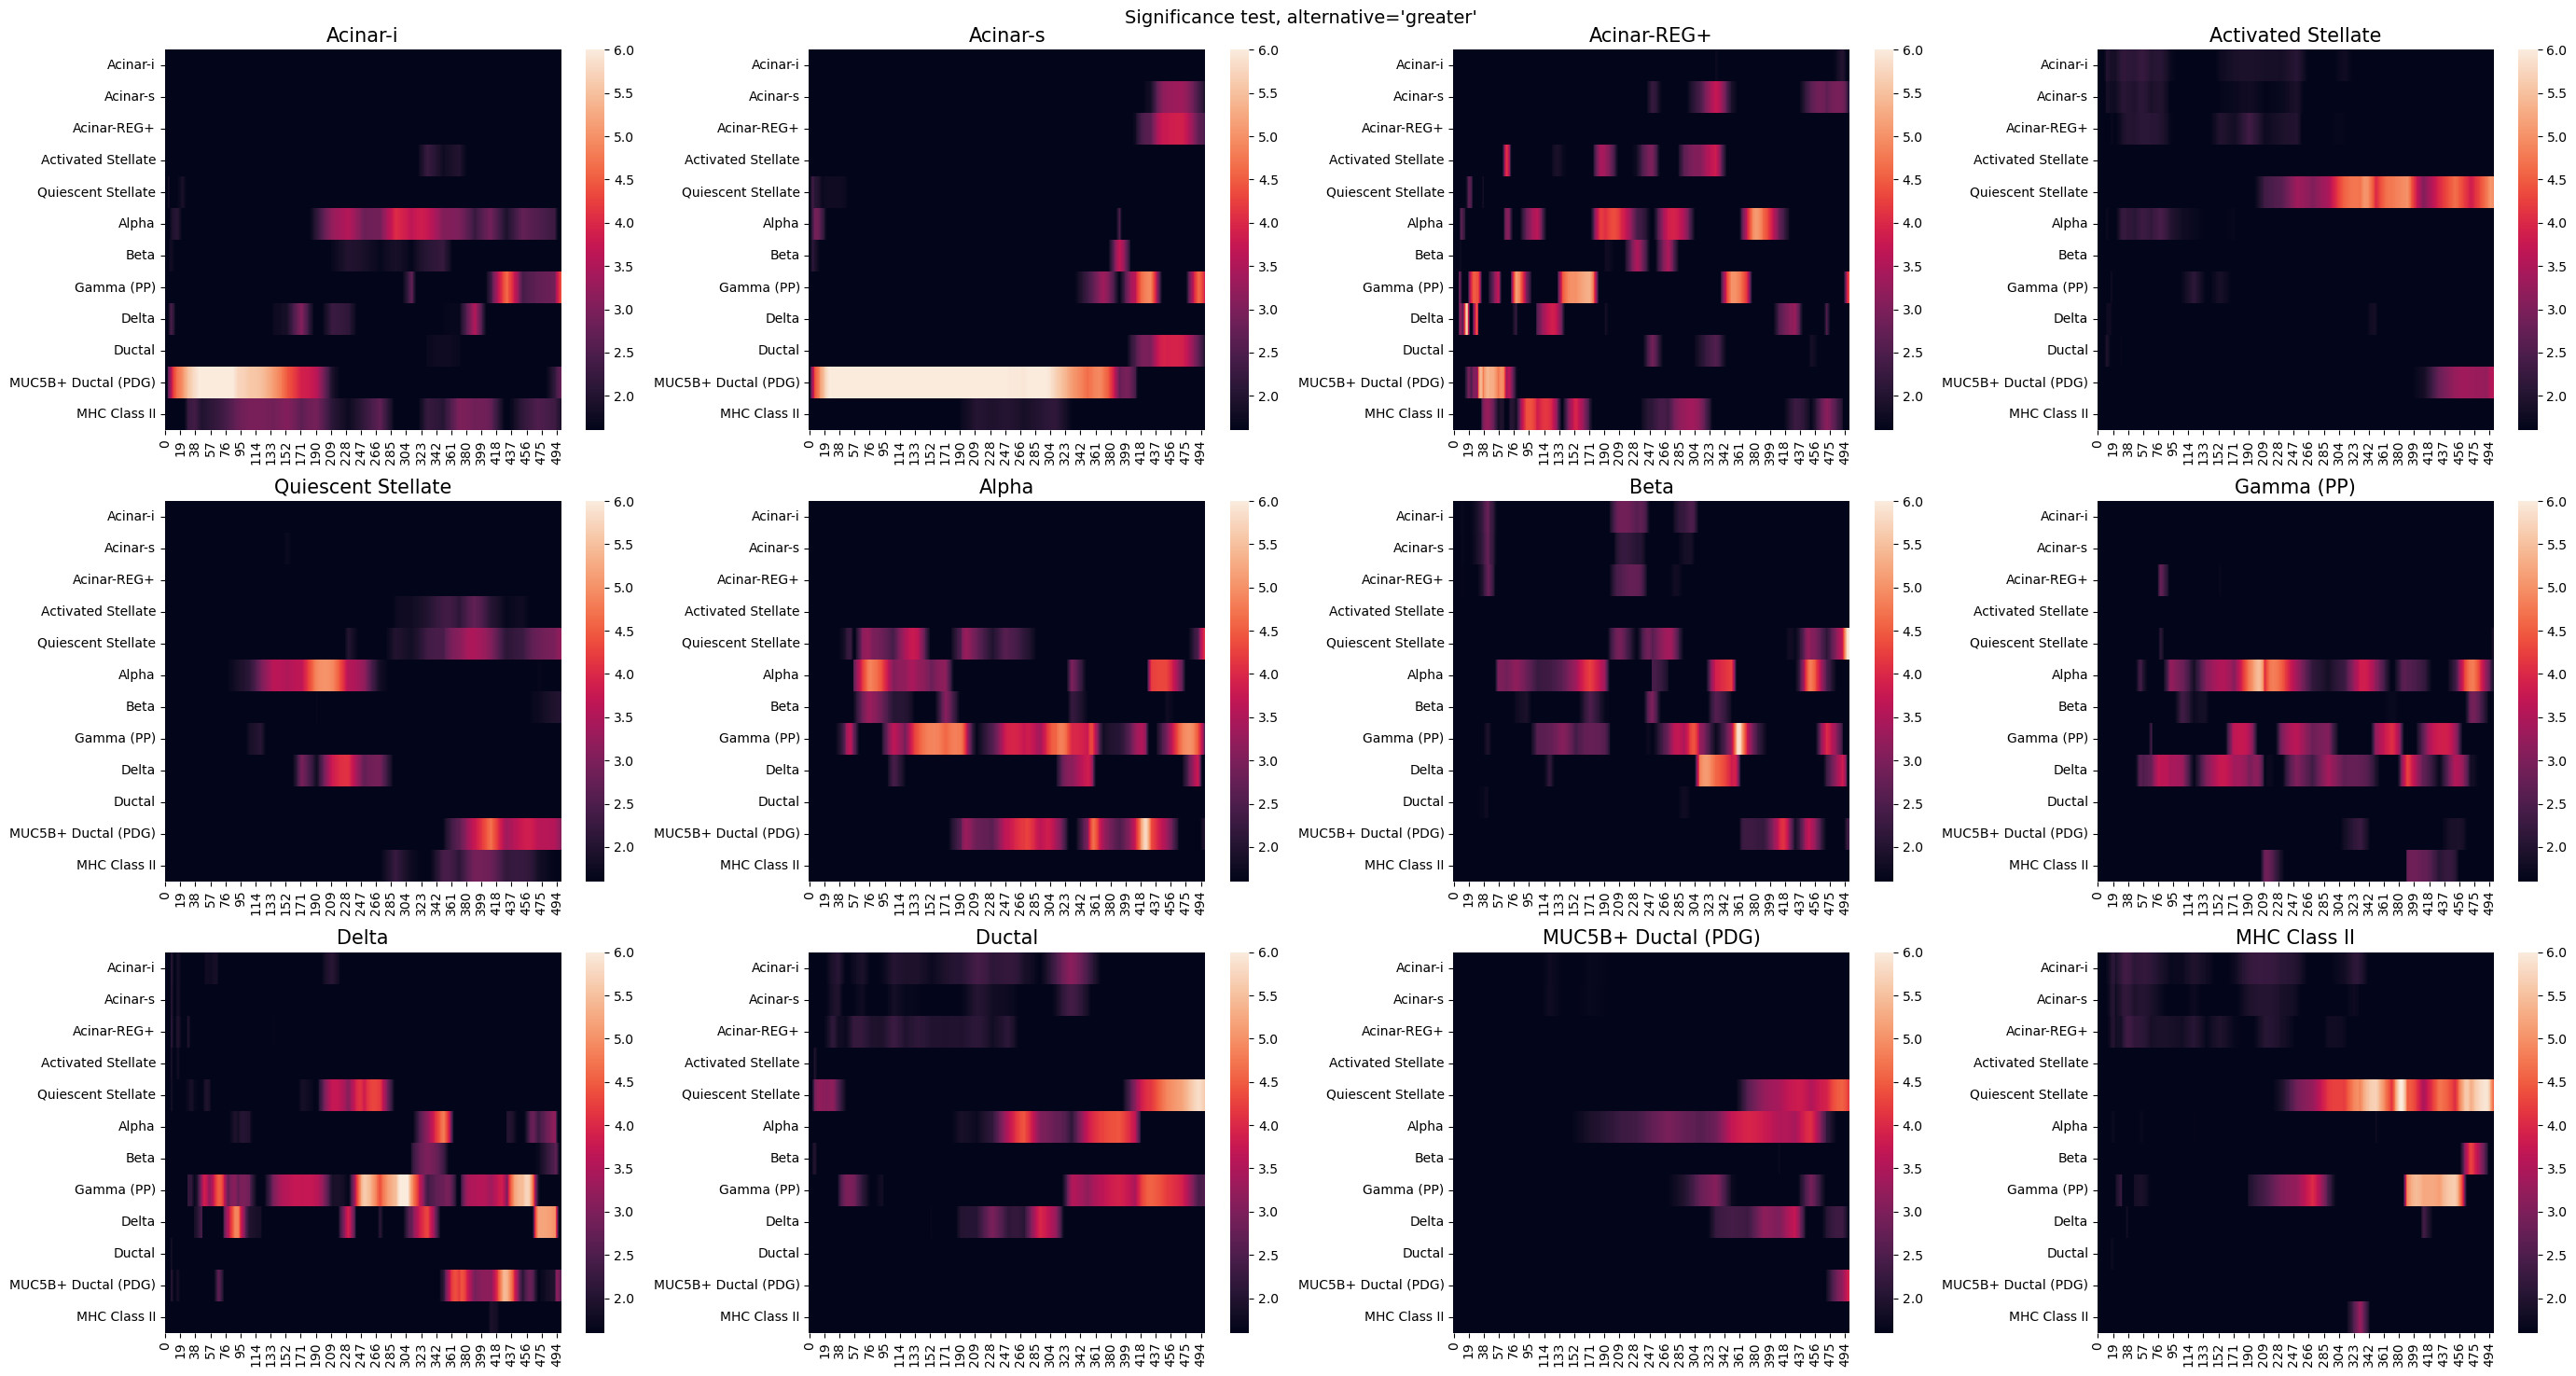

In [46]:
n_rows = 3
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize = (28,15))

for pivot_cell_type in range(normalized_coocur.shape[0]):

    row = pivot_cell_type // n_cols
    col = pivot_cell_type % n_cols
    ax = axes[row, col]

    sns.heatmap(-np.log10(significance_test_great[pivot_cell_type,:,:]), cmap="rocket", yticklabels = relevant_cluster_labels[:-1], vmin = 1.6, vmax=6, ax=ax)
    ax.set_title(f"{relevant_cluster_labels[pivot_cell_type]}")

plt.suptitle("Significance test, alternative='greater'", fontsize = 14)
plt.tight_layout()
plt.show()

## Different types of plots together for comparison

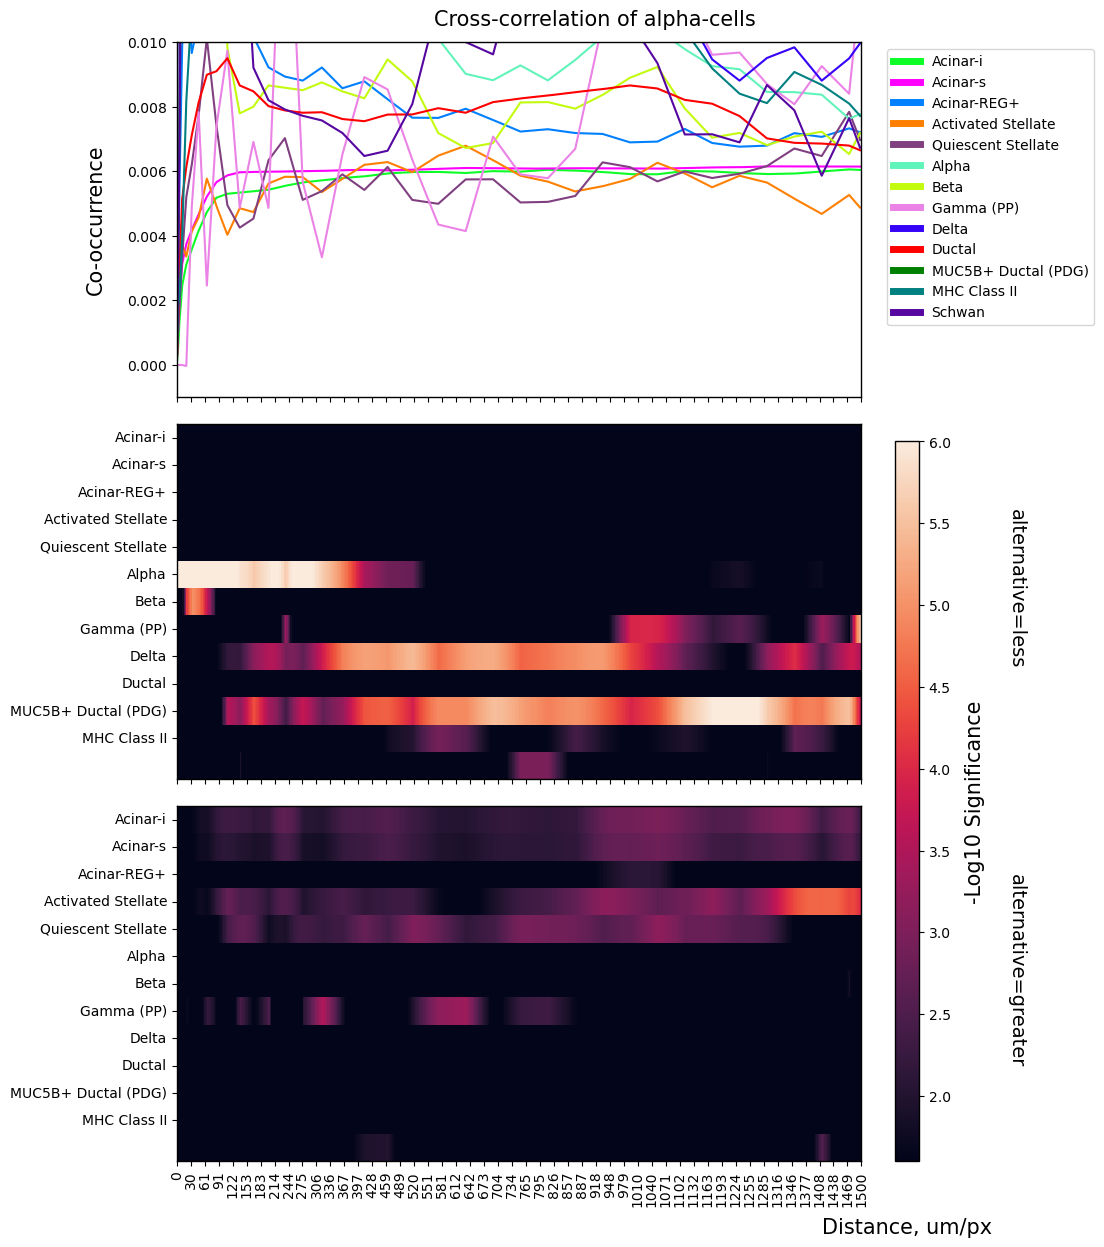

In [318]:
fig, axes = plt.subplots(3,1, figsize = (12,12), sharex=True)
pivot_cell_type = 5


ax_curves = axes[0]
for target_cell_type in range(normalized_coocur.shape[1]):
    ax_curves.plot(normalized_coocur[5,target_cell_type], label = relevant_cluster_labels[target_cell_type], color=colors[target_cell_type % len(colors)])
    ax_curves.legend(loc="upper right", bbox_to_anchor=(1.35, 1))
    ax_curves.set_ylim(-0.001, 0.01)
ax_curves.set_ylabel('Co-occurrence', labelpad=15)


ax_less = axes[1]
sns.heatmap(-np.log10(significance_test_less[pivot_cell_type,:,:]), cmap="rocket", yticklabels = relevant_cluster_labels[:-1], vmin = 1.6, vmax=6, ax=ax_less, cbar=False)
# Adjust the frame of the heatmap
ax_less.spines['top'].set_visible(True)
ax_less.spines['right'].set_visible(True)
ax_less.spines['bottom'].set_visible(True)
ax_less.spines['left'].set_visible(True)


ax_great = axes[2]
sns.heatmap(-np.log10(significance_test_great[pivot_cell_type,:,:]), cmap="rocket", yticklabels = relevant_cluster_labels[:-1], vmin = 1.6, vmax=6, ax=ax_great, cbar=False)


# Adjust the frame of the heatmap
ax_great.spines['top'].set_visible(True)
ax_great.spines['right'].set_visible(True)
ax_great.spines['bottom'].set_visible(True)
ax_great.spines['left'].set_visible(True)


# Adjust the frame of all plots
for ax in [ax_curves, ax_less, ax_great]:
    ax.spines['top'].set_linewidth(1) 
    ax.spines['right'].set_linewidth(1) 
    ax.spines['bottom'].set_linewidth(1)  # Adjust linewidth as needed
    ax.spines['left'].set_linewidth(1)

# Customize x-axis ticks
xlox = np.linspace(0,500,50)
xtix = [str(int(i)) for i in xlox*3] # *3 is getting back from scaling the sample which was used for avoiding memory issues while calculating sonar curves
plt.xticks(xlox,xtix)    


plt.tight_layout()

# Create a color bar
cbar_ax = fig.add_axes([0.75, 0.05, 0.02, 0.6])  # Adjust the values as needed
cbar = plt.colorbar(ax_less.collections[0], cax=cbar_ax)
cbar.set_label('-Log10 Significance', rotation=90, labelpad=10)
cbar.outline.set_linewidth(1)

# Adjust the linewidth of legend lines
legend_lines = ax_curves.get_legend().get_lines()
for line in legend_lines:
    line.set_linewidth(5.0)


# Add a text annotation on the right side of an alternative=less plot
ax_less.annotate("alternative=less", xy=(0,0), xytext=(620, 6), color="black",
             rotation=-90, ha='right', va='center', fontsize=14)

# Add a text annotation on the right side of an alternative=greater plot
ax_great.annotate("alternative=greater", xy=(0,0), xytext=(620, 6), color="black",
             rotation=-90, ha='right', va='center', fontsize=14)


plt.xlabel('Distance, um/px', labelpad=40) # Add x-axis label to the entire figure
plt.suptitle("Cross-correlation of alpha-cells", fontsize=15, y=1.01)
plt.show()

In [192]:
from matplotlib.backends.backend_pdf import PdfPages

In [319]:
# Create a PDF file
pdf_filename = "pancreas_sample2.pdf"
pdf_pages = PdfPages(pdf_filename)

for figure in range(normalized_coocur.shape[0]):

    # Initiating a figure
    fig, axes = plt.subplots(3,1, figsize = (12,12), sharex=True)

    pivot_cell_type = figure 

    # Sonar cross-correlation curves
    ax_curves = axes[0]
    for target_cell_type in range(normalized_coocur.shape[1]):

        y_maximum = normalized_coocur[pivot_cell_type,:,10:].mean() + normalized_coocur[pivot_cell_type,:,10:].std()*2.5

        ax_curves.plot(normalized_coocur[pivot_cell_type,target_cell_type], label = relevant_cluster_labels[target_cell_type], color=colors[target_cell_type % len(colors)])
        ax_curves.legend(loc="upper right", bbox_to_anchor=(1.35, 1))
        ax_curves.set_ylim(-y_maximum/40, y_maximum)
    ax_curves.set_ylabel('Co-occurrence', labelpad=15)
        
    # Significance heatmap of one-sided t-test, alternative=less
    ax_less = axes[1]
    sns.heatmap(-np.log10(significance_test_less[pivot_cell_type,:,:]), cmap="rocket", yticklabels = relevant_cluster_labels[:-1], vmin = 1.6, vmax=6, ax=ax_less, cbar=False)
    # ax_less.set_title("alternative=less")
    # Add a text annotation on the right side of an alternative=less plot
    ax_less.annotate("alternative=less", xy=(0,0), xytext=(620, 6), color="black",
             rotation=-90, ha='right', va='center', fontsize=14)
    # Adjust the frame of the heatmap
    ax_less.spines['top'].set_visible(True)
    ax_less.spines['right'].set_visible(True)
    ax_less.spines['bottom'].set_visible(True)
    ax_less.spines['left'].set_visible(True)

    # Significance heatmap of one-sided t-test, alternative=greater
    ax_great = axes[2]
    sns.heatmap(-np.log10(significance_test_great[pivot_cell_type,:,:]), cmap="rocket", yticklabels = relevant_cluster_labels[:-1], vmin = 1.6, vmax=6, ax=ax_great, cbar=False)
    # ax_great.set_title("alternative=greater")
    # Add a text annotation on the right side of an alternative=greater plot
    ax_great.annotate("alternative=greater", xy=(0,0), xytext=(620, 6), color="black",
             rotation=-90, ha='right', va='center', fontsize=14)
    # Adjust the frame of the heatmap
    ax_great.spines['top'].set_visible(True)
    ax_great.spines['right'].set_visible(True)
    ax_great.spines['bottom'].set_visible(True)
    ax_great.spines['left'].set_visible(True)

    for ax in [ax_curves, ax_less, ax_great]:
        ax.spines['top'].set_linewidth(1) 
        ax.spines['right'].set_linewidth(1) 
        ax.spines['bottom'].set_linewidth(1)  # Adjust linewidth as needed
        ax.spines['left'].set_linewidth(1)

    
    # Customize x-axis ticks
    xlox = np.linspace(0,500,50)
    xtix = [str(int(i)) for i in xlox*3] # *3 is getting back from scaling the sample which was used for avoiding memory issues while calculating sonar curves
    plt.xticks(xlox,xtix)   

    plt.tight_layout()

    # Create a color bar
    cbar_ax = fig.add_axes([0.75, 0.05, 0.02, 0.6])  # Adjust the values as needed
    cbar = plt.colorbar(ax_less.collections[0], cax=cbar_ax)
    cbar.set_label('-Log10 Significance', rotation=90, labelpad=10)
    cbar.outline.set_linewidth(1)

    # Adjust the linewidth of legend lines
    legend_lines = ax_curves.get_legend().get_lines()
    for line in legend_lines:
        line.set_linewidth(5.0)

    plt.xlabel('Distance, um/px', labelpad=40) # Add x-axis label to the entire figure
    plt.suptitle(f"Cross-correlation of {relevant_cluster_labels[figure]}", fontsize=15, y=1.01)

    # Save the current figure to the PDF file
    pdf_pages.savefig()

    # Close the current figure
    plt.close()

# Close the PDF file
pdf_pages.close()

plt.show()